In [4]:
import numpy as np
import json

from local.caching import load, save, save_exists

with open("./cache/meta_rxns.json") as j:
    meta_rxns = json.load(j)
LEN_RXN = len(meta_rxns)

class Numerizer:
    def __init__(self, lst: list[str]=list()) -> None:
        if not isinstance(lst, list): lst = list(lst)
        self._encoding: dict[str, int] = dict((s, i) for i, s in enumerate(lst))
        self._decoding: list[str] = lst

    def Encode(self, s: str):
        if s not in self._encoding:
            self._encoding[s] = len(self._encoding)
            self._decoding.append(s)
        return self._encoding[s]
    
    def Decode(self, i: int):
        return self._decoding[i]
    
    def __len__(self):
        return len(self._encoding)
    
# encoding = Numerizer(meta_rxns)

enc:Numerizer = load("enc")
lst = [""]*len(enc._decoding)
for k, i in enc._encoding.items():
    lst[i] = k
enc._decoding = lst

recovering & decompressing cached data from [{WORKSPACE}/main/biocyc_run/cache/enc.pkl.gz]


In [5]:
dq_sorted = load("dq_ss")
dq_sorted.shape

recovering & decompressing cached data from [{WORKSPACE}/main/biocyc_run/cache/dq_ss.pkl.gz]


(2701414, 7)

In [6]:
save_name = "dist_mat"
redo = False
# redo = True

if not redo and save_exists(save_name):
    sqmat, mat = load(save_name)
    mat_enc = load(f"{save_name}-enc")
    
else:
    rxns = set()
    min_dq = 9999
    max_dq = 0
    mat_enc = Numerizer()
    for ia, ib, dq, gq, c, adq, agq in dq_sorted:
        a, b = (enc.Decode(int(x)) for x in [ia, ib])
        # print(a, b)
        mat_enc.Encode(a)
        mat_enc.Encode(b)
        min_dq = min(adq, min_dq)
        max_dq = max(adq, max_dq)

    # no_data_penalty = max_d*2
    print(len(mat_enc), min_dq, max_dq)

    mat = np.zeros(shape=(len(mat_enc), len(mat_enc)))
    for ia, ib, dq, gq, c, adq, agq in dq_sorted:
        a, b = (enc.Decode(int(x)) for x in [ia, ib])
        
        ja, jb = (mat_enc.Encode(x) for x in [a, b])
        mat[ja, jb] = adq
        mat[jb, ja] = adq

    sqmat = 1 - mat/max_dq # score to dist
    sqmat = sqmat*sqmat # squared dists
    print(mat.shape)

    save(save_name, (sqmat, mat), compression_level=5)
    save(f"{save_name}-enc", mat_enc)

recovering & decompressing cached data from [{WORKSPACE}/main/biocyc_run/cache/dist_mat.pkl.gz]
recovering & decompressing cached data from [{WORKSPACE}/main/biocyc_run/cache/dist_mat-enc.pkl.gz]


/home/tony/Utilities/mambaforge/envs/445/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.

/home/tony/Utilities/mambaforge/envs/445/lib/python3.10/site-packages/seaborn/matrix.py:530: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



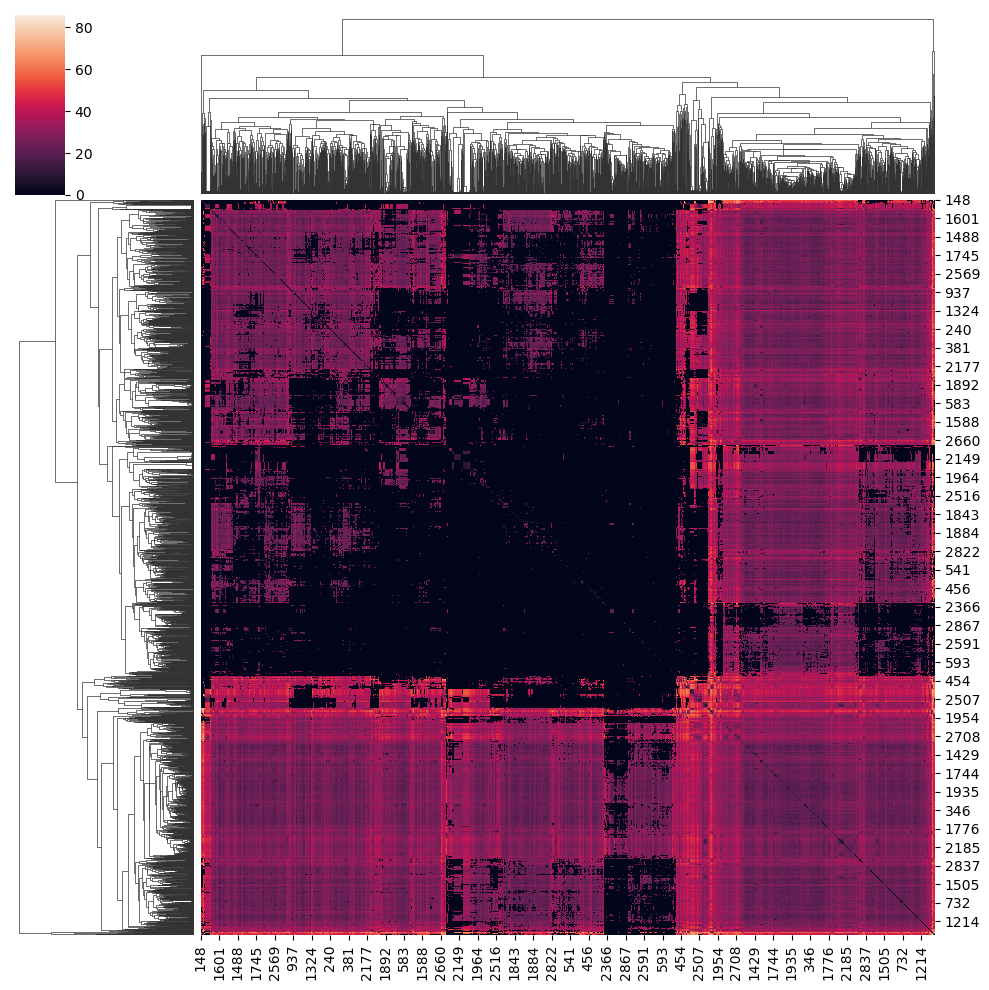

In [7]:
import seaborn as sns

heat = sns.clustermap(mat)
heat

In [8]:
dgram = heat.dendrogram_col.dendrogram
D = np.array(dgram['dcoord'])
I = np.array(dgram['icoord'])
links = heat.dendrogram_col.linkage

In [9]:
from typing import Any

_tree: dict[int, Any] = dict((n, n) for n in range(len(mat)))
next_branch = len(_tree)

for i, (ia, ib, dist, count) in enumerate(links):
    a = _tree[ia]
    b = _tree[ib]

    new = next_branch
    next_branch+=1

    _tree[new] = (a, b, dist, count)
    del _tree[ia]
    del _tree[ib]

tree = next(iter(_tree.values()))

In [10]:
from biocyc_facade.pgdb import Pgdb, Dat, Traceable
import re

def _clean_name(n):
    for f in [
        lambda s: re.sub(r"<[\w\/]*>|[:;\&\(\)\[\]\{\}]+", "", s, count=99),
        lambda s: re.sub(r",", "_", s, count=99),
    ]:
        n = f(n)
    return n

meta = Pgdb("../../data/txyl_local/biocyc_facade_pgdbs/meta26_0.1_2.pgdb")
meta_rxns = meta.GetDataTable(Dat.REACTIONS)
rname = dict((k, _clean_name(v)) for k, v in meta.Trace(Traceable.REACTIONS, Traceable.RXN_COMMON_NAME))
r2e = dict((k, _clean_name(v)) for k, v in meta.Trace(Traceable.REACTIONS, Traceable.ENZ_COMMON_NAME))

def get_name(rid):
    return rname.get(rid, r2e.get(rid, rid))

In [11]:
def _nwk(tree):
    if isinstance(tree, int):
        rxn_id = mat_enc.Decode(tree)
        name = get_name(rxn_id)
        return f"{rxn_id}--{name}"
    
    a, b, dist, count = tree
    an = _nwk(a)
    bn = _nwk(b)
    return f"({an}:{dist}, {bn}:{dist})"

nwk = _nwk(tree)
with open("./cache/sns_avtree.nwk", "w") as f:
    f.write(nwk)

In [12]:
pwys = meta.GetDataTable(Dat.PATHWAYS)
pnames = dict(meta.Trace(Traceable.PATHWAYS, Traceable.PATH_COMMON_NAME))

In [13]:
def get_rxns(pwy_k):
    data = pwys.get(pwy_k, {})
    rxns = data.get("REACTION-LIST", [])
    
    while True:
        found = False
        for i in range(len(rxns)-1, -1, -1):
            r = rxns[i]
            if r in pwys:
                found = True
                rxns += get_rxns(r)
                rxns.pop(i)
        if not found: break
    return rxns

# [get_name(r) for r in get_rxns("PWY-6001")]

In [14]:
len(pwys)

3388

In [15]:
leaves = set(mat_enc._decoding)
to_test = []
for p in pwys:
    all_r = get_rxns(p)
    rxns = [r for r in all_r if r in leaves]
    if len(rxns) < 2: continue
    to_test.append((p, len(all_r), rxns))

len(to_test)

761

In [16]:
R_IN_TREE = 2981
ALL_R = 19597
P_IN_TREE = R_IN_TREE / ALL_R

def nthHarmonic(n) :
    # H1 = 1
    harmonic = 1.00
    # Hn = 1 + 1/2 + 1/3 ... + 1/n
    for i in range(2, n + 1) :
        harmonic += 1 / i
    return harmonic

def exp(k):
    return R_IN_TREE * nthHarmonic(k)

In [17]:
def _children(tree):
    if isinstance(tree, int):
        rxn_id = mat_enc.Decode(tree)
        return {rxn_id}
    
    a, b, dist, count = tree
    ag = _children(a)
    bg = _children(b)
    return ag.union(bg)

def num_in(tree, target: set[str]):
    if isinstance(tree, int):
        rxn_id = mat_enc.Decode(tree)
        return 1 if rxn_id in target else 0
    
    a, b, dist, count = tree
    return num_in(a, target) + num_in(b, target)

def min_set(tree, target: set[str]) -> set[str]:
    if isinstance(tree, int):
        rxn_id = mat_enc.Decode(tree)
        if len(target) == 1 and rxn_id in target:
            return {rxn_id}
        else:
            return _children(tree)
    
    a, b, dist, count = tree
    if num_in(a, target) == len(target):
        return min_set(a, target)
    
    if num_in(b, target) == len(target):
        return min_set(b, target)
    
    return _children(tree)

ms = min_set(tree, {'RXN-8502', 'RXN-8497'})
len(ms)

2968

In [18]:
np.random.seed(23)
mapped_rxns = mat_enc._decoding.copy()
# mrxn_lst = list(meta_rxns
size = 2

replicates = 25
ntrials = 25
ref = []
for s in [2, 5, 10, 15, 20, 25, 30, 35]:
    samples = []
    for i in range(ntrials):
        print(f"\r{(i+1)/ntrials*100:03.0f}% | {s}      ", end="")
        _samples = []
        while len(_samples) < replicates:
            rxns = np.random.choice(mapped_rxns, size)
            # print(rxns)
            _samples.append(len(min_set(tree, set(rxns))))
            # break

        samples.append(np.mean(_samples))

    ref.append((s, np.mean(samples)))

100% | 35      

In [19]:
max_l = 0
placements = []
for p, c, rxns in to_test:
    ms = min_set(tree, set(rxns))
    o = len(ms)
    # max_l = max(c, max_l)
    max_l = max(len(rxns), max_l)
    placements.append((len(rxns), len(ms), c, p))

max_l

33

In [50]:
from typing import Any
from plotly import graph_objects as go, subplots as sp
from local.figures import layout, xaxis_desc, yaxis_desc

fig = sp.make_subplots(
    rows=1, cols=1, shared_xaxes=True, shared_yaxes=False, horizontal_spacing=0.05, vertical_spacing=0.02,
)

fig.add_trace(
    go.Scatter(
        x = [t[0] for t in placements],
        y = [t[1] for t in placements],
        mode="markers",
        marker=dict(
            size=5,
            symbol="circle",
            color=[f"rgba(0, 156, 255, {t[0]/t[2]})" for t in placements],
        ),
        text = [f"{t[0]}/{t[2]} | {pnames.get(t[3], t[3])}" for t in placements],
        showlegend=False,
    ),
    row=1, col=1,
)

fig.add_trace(
    go.Scatter(
        x = [t[0] for t in ref],
        y = [t[1] for t in ref],
        # mode="markers",
        showlegend=False,
    ),
    row=1, col=1,
)

plotted_y = []
for t in placements:
    x, y = t[0], t[1]
    if y > 1500: continue
    if any(abs(y-py) < 100 for py in plotted_y): continue
    a = t[0]/t[2]
    if a < 0.5: continue

    plotted_y.append(y)

    n=pnames.get(t[3], t[3])
    lines = []
    b = []
    for word in n.split(" "):
        b.append(word)
        if len(b)>1:
            lines.append(" ".join(b))
            b.clear()
    lines.append(" ".join(b))
    ln = "<br>".join(lines)

    fig.add_annotation(
        x=x, y=y,
        ax=50, ay=-10,
        text=n,
        showarrow=True,
        xanchor="left",
        arrowhead=1,
    )

fig.update_annotations(
    font=dict(
        size=16,
    ),
)
_layout:Any = layout.copy()
_layout.update(dict(
    width = 800,
    height =600,
    xaxis=dict(title="|w|", range=(-1, 17), **xaxis_desc),
    yaxis=dict(title="L(w)", **yaxis_desc),
))
fig.update_layout(go.Layout(_layout))
# fig.show()

In [18]:
[r in mapped_rxns for r in rxns]

[True, True]

In [19]:
len(min_set(tree, rxns))

2968

In [20]:
import math

math.comb(250, 5)

7817031300

In [21]:
# N, k in tree
# p = 1 in tree = 2981 / 19597
# N choose k * (k * p), for pwy of size N with k rxns in tree
# 
# frac in tree = 2981 / 19597
# k in tree, expect on average how big a group to contain k
# mode of binomial to contain

In [22]:
len(meta_rxns), len(mat)

(19597, 2981)